In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
import pandas as pd
from mpmath import cot
from matplotlib.colors import Normalize as Normalize
import matplotlib.patches as patches

# Define the time, location, and turbine specs

In [8]:
nt = 48*2+1
times   = pd.date_range('2019-08-15 08:00:00', periods=nt, freq='30min')
loc     = coord.EarthLocation(lon=-105.23 * u.deg,
                              lat=39.91 * u.deg)

tower_height = 70.0 # meters
tower_width  = 4.0 # meters
rotor_rad    = 40.0 # meters

tower_shadow_weight = 0.9 # how much incoming radiation is blocked out by the tower? 
rotor_shadow_weight = 0.2 # how much of the swept area do the blades cover? 0.2?

# Save directory

In [9]:
savedir = '/home/phawbeck/ShadowCast/'
showAnim = True

# Initialize variables

In [10]:
azi_ang = np.zeros((nt))
elv_ang = np.zeros((nt))
shadow_length_tower     = np.zeros((nt))
shadow_length_rotor_top = np.zeros((nt))
shadow_length_rotor_bot = np.zeros((nt))

# Loop over all times and calculate elevation angle

In [11]:
for tt,time in enumerate(times):
    sun_time = Time(time) #UTC time
 
    sunpos = coord.AltAz(obstime=sun_time, location=loc)
    #zenith = coord.get_sun(sun_time).transform_to(sunpos).zen
    alt    = coord.get_sun(sun_time).transform_to(sunpos).alt
    azi    = coord.get_sun(sun_time).transform_to(sunpos).az
    elv_ang[tt] = alt.degree
    azi_ang[tt] = azi.degree
    #zen_ang[tt] = zenith.degree

# Calculate the shadow length and angle
https://rechneronline.de/sehwinkel/shadow-casting.php

#### (From Wikipedia) 
However, despite tradition, the most commonly accepted convention for analyzing solar irradiation, e.g. for solar energy applications, is clockwise from due north, so east is 90°, south is 180°, and west is 270°.

In [12]:
for tt in range(0,nt):
    shadow_length_tower[tt]     = tower_height*cot(np.radians(elv_ang[tt]))
    shadow_length_rotor_top[tt] = (tower_height+rotor_rad)*cot(np.radians(elv_ang[tt]))
    shadow_length_rotor_bot[tt] = (tower_height-rotor_rad)*cot(np.radians(elv_ang[tt]))
shadow_length_tower[elv_ang <=0.0] = np.nan
shadow_length_rotor_top[elv_ang <=0.0] = np.nan
shadow_length_rotor_bot[elv_ang <=0.0] = np.nan
shadow_ang = azi_ang - 180.0
shadow_ang[elv_ang <= 0.0] = np.nan
shadow_ang[shadow_ang < 0.0] += 360.0

/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


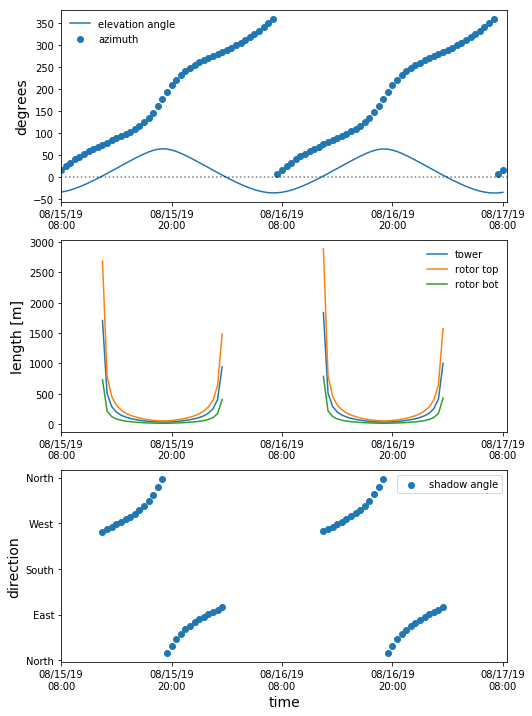

In [13]:
#print np.nanmax(elv_ang)
#print np.nanmin(shadow_length)
plt.figure(figsize=(8,12))
solarplt = plt.subplot(311)
plt.plot(range(0,nt),elv_ang,label='elevation angle')
plt.axhline(0.0,c='k',alpha=0.5,ls=':')
plt.scatter(range(0,nt),azi_ang,label='azimuth')
plt.ylabel('degrees',size=14)
plt.legend(frameon=False)
#plt.xlim(0,nt)

plt.subplot(312,sharex=solarplt)
plt.plot(shadow_length_tower,label='tower')
plt.plot(shadow_length_rotor_top,label='rotor top')
plt.plot(shadow_length_rotor_bot,label='rotor bot')
plt.legend(frameon=False)
plt.ylabel('length [m]',size=14)
plt.xlim(0,nt)

plt.subplot(313,sharex=solarplt)
plt.scatter(range(0,nt),shadow_ang,label='shadow angle')
plt.xlabel('time',size=14)
plt.ylabel('direction',size=14)
plt.yticks([0.0,90.0,180.0,270.0,360.0], ['North','East','South','West','North'])
plt.xlim(0,nt)
plt.xticks([0,24,48,72,96],times[[0,24,48,72,96]].strftime("%m/%d/%y\n%H:%M"))
plt.legend()
plt.show()

# Generate a mesh assuming tower in center

In [14]:
dx,dy = 1.0,1.0
lx,ly = 1000.0, 1000.0
x = np.arange(0,lx+0.1,dx) - lx/2.0
xc = 0.5*(x[1:] + x[:-1])
y = np.arange(0,ly+0.1,dy) - ly/2.0
yc = 0.5*(y[1:] + y[:-1])
xy,yx = np.meshgrid(x,y)
xyc, yxc = np.meshgrid(xc,yc)
shadow = np.ones((np.shape(xyc)[0],np.shape(xyc)[1],nt))

distance = np.sqrt(xyc**2 + yxc**2)
angle            = np.degrees(np.arctan(xyc/yxc))
angle[yxc<0.0]   = angle[yxc<0.0] + 180.0
angle[angle<0.0] = angle[angle<0.0] + 360.0

# Calculate turbine shadow on grid

Find cells that are between these and add a buffer for cells that are close?

In [15]:
for toi in range(0,nt):
    fig = plt.figure(figsize=(12,6.5))
    # Make "sunlight" a function of sun elevation angle
#    shadow[:,:,toi] = elv_ang[toi]
    D     = shadow_length_tower[toi]
    theta = np.radians(shadow_ang[toi])
    plt.subplot(aspect='equal')
    mask = np.ones(np.shape(xyc))
    
    htw = tower_width/2.0
    # find the left and right edges of the tower shadow by adding/subtracting 90 degrees from the shadow angle
    tower_left_xs, tower_left_ys = htw*np.sin(np.radians(shadow_ang[toi]-90.0)), htw*np.cos(np.radians(shadow_ang[toi]-90.0))
    tower_rght_xs, tower_rght_ys = htw*np.sin(np.radians(shadow_ang[toi]+90.0)), htw*np.cos(np.radians(shadow_ang[toi]+90.0))
    tower_left_xe, tower_left_ye = D*np.sin(theta)+tower_left_xs, D*np.cos(theta)+tower_left_ys
    tower_rght_xe, tower_rght_ye = D*np.sin(theta)+tower_rght_xs, D*np.cos(theta)+tower_rght_ys
    # Find the slopes & intercepts of these lines to find the cells that are between the two
    tower_left_slope = (tower_left_ys-tower_left_ye) / (tower_left_xs-tower_left_xe)
    tower_rght_slope = (tower_rght_ys-tower_rght_ye) / (tower_rght_xs-tower_rght_xe)
    tower_left_int   = tower_left_ys - tower_left_slope*tower_left_xs
    tower_rght_int   = tower_rght_ys - tower_rght_slope*tower_rght_xs
    tower_axis_slope = (tower_left_ys-tower_rght_ys) / (tower_left_xs-tower_rght_xs)
    # Make is so that the angle is 0 in the direction of the shadow... remove 180 > A > 270
    shadow_angle = angle-shadow_ang[toi]
    shadow_angle[shadow_angle<0.0] += 360.0
    # Find points between the two lines...
    mask[((yxc>=tower_left_slope*xyc+tower_left_int) & (yxc<=tower_rght_slope*xyc+tower_rght_int)) | 
         ((yxc<=tower_left_slope*xyc+tower_left_int) & (yxc>=tower_rght_slope*xyc+tower_rght_int))] = (1.0 - tower_shadow_weight)
    # Find points that are less than the shadow distance
    mask[distance>shadow_length_tower[toi]] = 1.0
    # Find points in the direction of the shadow
    mask[(shadow_angle>90.0) & (shadow_angle<270.0)] = 1.0
    
    # Define the ellipse!
    g_ell_center = (D*np.sin(theta), D*np.cos(theta))
    g_ell_height = rotor_rad
    g_ell_width  = shadow_length_rotor_top[toi] - shadow_length_rotor_bot[toi]
    ell_angle    = np.degrees(np.arctan2(D*np.cos(theta), D*np.sin(theta)))
    # Get the angles of the axes
    cos_angle = np.cos(np.radians(180.-ell_angle))
    sin_angle = np.sin(np.radians(180.-ell_angle))
    # Find the distance of each gridpoint from the ellipse
    exc = xyc - g_ell_center[0]
    eyc = yxc - g_ell_center[1]
    exct = exc * cos_angle - eyc * sin_angle
    eyct = exc * sin_angle + eyc * cos_angle 
    # Get the radial distance away from ellipse: cutoff at r = 1
    rad_cc = (exct**2/(g_ell_width/2.)**2) + (eyct**2/(g_ell_height/2.)**2)

    g_ellipse = patches.Ellipse(g_ell_center, g_ell_width, g_ell_height, angle=ell_angle, 
                                fill=False, edgecolor='green', linewidth=2)
    mask[rad_cc<=1.0] = mask[rad_cc<=1.0]*(1.0-rotor_shadow_weight)

    shadow[:,:,toi] = mask
    plt.subplot(121,aspect='equal')
    plt.tick_params(labelsize=12)
    shdwplt = plt.pcolormesh(xy,yx,shadow[:,:,toi],norm=Normalize(0.0,1.0),cmap=cm.gray)
    #plt.colorbar()
    plt.plot([0,0],[0,tower_height/2.0],c='k')
    plt.scatter(0,tower_height/2.0,color='k',marker='2',s=300)
    plt.ylabel('South-North [m]',size=14)
    plt.xlabel('West-East [m]',size=14)
    #plt.scatter(D*np.sin(theta), D*np.cos(theta),c='k')
    plt.xlim((-200,200))
    plt.ylim((-200,200))
    
    plt.subplot(122,aspect='equal')
    plt.tick_params(labelsize=12)
    plt.ylabel('South-North [m]',size=14)
    plt.xlabel('West-East [m]',size=14)
    maskplt = plt.pcolormesh(xy,yx,shadow[:,:,toi]*elv_ang[toi]*7.0,norm=Normalize(0.0,400.0),cmap=cm.hot)
    #plt.colorbar()
    plt.plot([0,0],[0,tower_height/2.0],c='k')
    plt.scatter(0,tower_height/2.0,color='k',marker='2',s=300)
    #plt.scatter(D*np.sin(theta), D*np.cos(theta),c='k')
    plt.xlim((-200,200))
    plt.ylim((-200,200))
    plt.suptitle(times[toi],size=14)
    
    cax1 = fig.add_axes([0.125, 0.88, 0.355, 0.03])
    cax2 = fig.add_axes([0.545, 0.88, 0.355, 0.03])
    cax1.tick_params(labelsize=12)
    cax2.tick_params(labelsize=12)

    plt.colorbar(shdwplt,cax1,orientation='horizontal')
    plt.colorbar(maskplt,cax2,orientation='horizontal')
    cax1.text(0.5,1.1,'Shade Weight',ha='center',va='bottom',size=14)
    cax2.text(0.5,1.1,'Pseudo-Heat Flux [W m$^{-1}$]',ha='center',va='bottom',size=14)
    if showAnim: 
        pltstr  = 'shadow'
        #savestr = '{}img/anim/{}_{}.png'.format(savedir,pltstr,str(times[toi]).replace(' ','_').replace(':',''))
        savestr = '{}img/anim/{}_{:05d}.png'.format(savedir,pltstr,toi)
        plt.savefig(savestr)
        plt.clf()
    else:
        plt.draw()
        plt.pause(0.10)
        plt.clf()

/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater_equal
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encou

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

<Figure size 864x468 with 0 Axes>

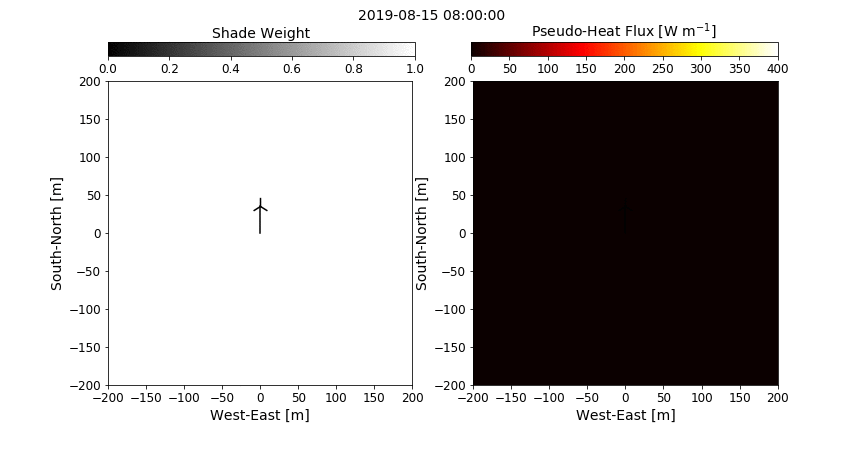

In [16]:
if showAnim:
    import glob
    import os
    from IPython.display import Image

    gif_name = '{}'.format(pltstr)
    file_list = glob.glob('{}img/anim/*.png'.format(savedir)) # Get all the pngs in the directory
    list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images

    with open('{}image_list.txt'.format(savedir), 'w') as file:
        for item in file_list:
            file.write("%s\n" % item)

    os.system('convert -delay 10 @{}image_list.txt {}img/{}.gif'.format(savedir,savedir,gif_name))
    gifstr = '{}img/{}.gif'.format(savedir,pltstr)
    with open(gifstr,'rb') as gfile:
        display(Image(gfile.read()))

# This is now a <i>class</i> called "shadowCast"

In [17]:
from ShadowCast import shadowCast
start_date = '2019-07-01 08:00:00'
shadow1minS  = shadowCast(date_start=start_date,data_freq='1min',ntimes=24*60+1,
                    latoi=39.91,lonoi=-105.23,tower_height=50.0,tower_width=4.0,dx=4.0,dy=4.0,lx=1000.0,ly=1000.0)
print 'done 1 min'
shadow10minS = shadowCast(date_start=start_date,data_freq='10min',ntimes=24*6+1,
                    latoi=39.91,lonoi=-105.23,tower_height=50.0,tower_width=4.0,dx=4.0,dy=4.0,lx=1000.0,ly=1000.0)
print 'done 10 min'
shadow30minS = shadowCast(date_start=start_date,data_freq='30min',ntimes=24*2+1,
                    latoi=39.91,lonoi=-105.23,tower_height=50.0,tower_width=4.0,dx=4.0,dy=4.0,lx=1000.0,ly=1000.0)
print 'done 30 min'
shadow60minS = shadowCast(date_start=start_date,data_freq='60min',ntimes=24+1,
                    latoi=39.91,lonoi=-105.23,tower_height=50.0,tower_width=4.0,dx=4.0,dy=4.0,lx=1000.0,ly=1000.0)

ShadowCast.py:84: RuntimeWarning: invalid value encountered in less
  shadow_ang[shadow_ang < 0.0] += 360.0
ShadowCast.py:112: RuntimeWarning: invalid value encountered in less
  shadow_angle[shadow_angle<0.0] += 360.0
ShadowCast.py:115: RuntimeWarning: invalid value encountered in greater_equal
  ((self.yxc<=tower_left_slope*self.xyc+tower_left_int) & (self.yxc>=tower_rght_slope*self.xyc+tower_rght_int))] = (1.0 - self.tower_shadow_weight)
ShadowCast.py:115: RuntimeWarning: invalid value encountered in less_equal
  ((self.yxc<=tower_left_slope*self.xyc+tower_left_int) & (self.yxc>=tower_rght_slope*self.xyc+tower_rght_int))] = (1.0 - self.tower_shadow_weight)
ShadowCast.py:117: RuntimeWarning: invalid value encountered in greater
  mask[distance>shadow_length_tower[toi]] = 1.0
ShadowCast.py:119: RuntimeWarning: invalid value encountered in greater
  mask[(shadow_angle>90.0) & (shadow_angle<270.0)] = 1.0
ShadowCast.py:119: RuntimeWarning: invalid value encountered in less
  mask[(shadow

done 1 min
done 10 min
done 30 min


In [18]:
xy, yx = shadow1minS.xy, shadow1minS.yx
avg_shadow1minS  = np.zeros(np.shape(shadow1minS.xyc))
avg_shadow10minS = np.zeros(np.shape(shadow1minS.xyc))
avg_shadow30minS = np.zeros(np.shape(shadow1minS.xyc))
avg_shadow60minS = np.zeros(np.shape(shadow1minS.xyc))
day1minS  = 0.0
day10minS = 0.0
day30minS = 0.0
day60minS = 0.0
for tt in range(0,np.shape(shadow1minS.times)[0]):
    if np.shape(np.where(shadow1minS.shadow[:,:,tt] == 1.0))[1] != int(np.shape(xy)[0]-1)*int(np.shape(xy)[1]-1):
        avg_shadow1minS += shadow1minS.shadow[:,:,tt]
        day1minS += 1.0
print 'done 1 min'
for tt in range(0,np.shape(shadow10minS.times)[0]):
    if np.shape(np.where(shadow10minS.shadow[:,:,tt] == 1.0))[1] != int(np.shape(xy)[0]-1)*int(np.shape(xy)[1]-1):
        avg_shadow10minS += shadow10minS.shadow[:,:,tt]
        day10minS += 1.0
print 'done 10 min'
for tt in range(0,np.shape(shadow30minS.times)[0]):
    if np.shape(np.where(shadow30minS.shadow[:,:,tt] == 1.0))[1] != int(np.shape(xy)[0]-1)*int(np.shape(xy)[1]-1):
        avg_shadow30minS += shadow30minS.shadow[:,:,tt]
        day30minS += 1.0
print 'done 30 min'
for tt in range(0,np.shape(shadow60minS.times)[0]):
    if np.shape(np.where(shadow60minS.shadow[:,:,tt] == 1.0))[1] != int(np.shape(xy)[0]-1)*int(np.shape(xy)[1]-1):
        avg_shadow60minS += shadow60minS.shadow[:,:,tt]
        day60minS += 1.0

done 1 min
done 10 min
done 30 min


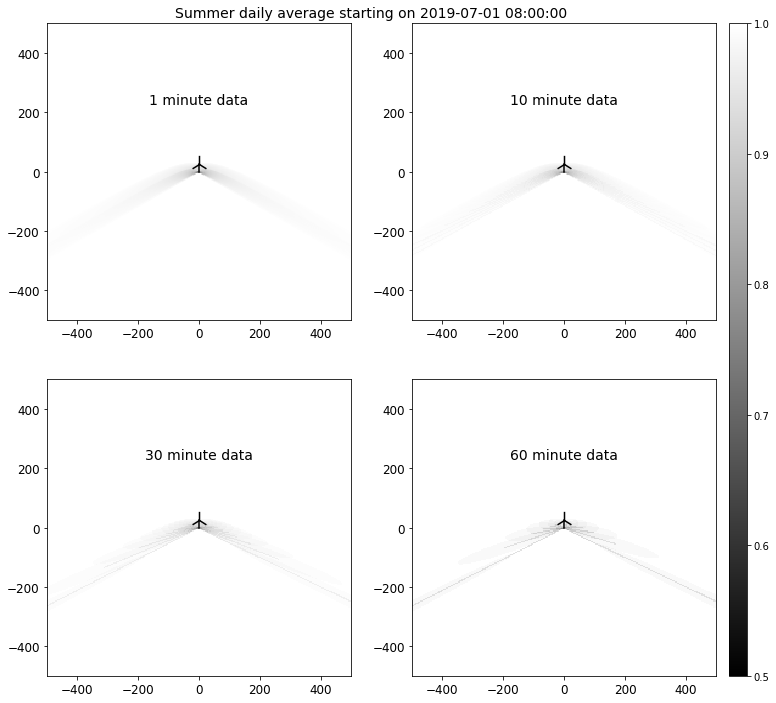

In [19]:
fig = plt.figure(figsize=(12,12))
sh1min = plt.subplot2grid((2,2),(0,0))
sh10min = plt.subplot2grid((2,2),(0,1))
sh30min = plt.subplot2grid((2,2),(1,0))
sh60min = plt.subplot2grid((2,2),(1,1))
sh1min.tick_params(labelsize=12)
sh10min.tick_params(labelsize=12)
sh30min.tick_params(labelsize=12)
sh60min.tick_params(labelsize=12)

plt1min = sh1min.pcolormesh(xy,yx,avg_shadow1minS/day1minS,norm=Normalize(0.5,1.0),cmap=cm.gray)
sh1min.plot([0,0],[0,shadow1minS.tower_height/2.0],c='k')
sh1min.scatter(0,shadow1minS.tower_height/2.0,color='k',marker='2',s=300)
sh1min.text(0.0,220,'1 minute data',ha='center',va='bottom',size=14)

sh10min.pcolormesh(xy,yx,avg_shadow10minS/day10minS,norm=Normalize(0.5,1.0),cmap=cm.gray)
sh10min.plot([0,0],[0,shadow10minS.tower_height/2.0],c='k')
sh10min.scatter(0,shadow10minS.tower_height/2.0,color='k',marker='2',s=300)
sh10min.text(0.0,220,'10 minute data',ha='center',va='bottom',size=14)

sh30min.pcolormesh(xy,yx,avg_shadow30minS/day30minS,norm=Normalize(0.5,1.0),cmap=cm.gray)
sh30min.plot([0,0],[0,shadow30minS.tower_height/2.0],c='k')
sh30min.scatter(0,shadow30minS.tower_height/2.0,color='k',marker='2',s=300)
sh30min.text(0.0,220,'30 minute data',ha='center',va='bottom',size=14)

sh60min.pcolormesh(xy,yx,avg_shadow60minS/day60minS,norm=Normalize(0.5,1.0),cmap=cm.gray)
sh60min.plot([0,0],[0,shadow60minS.tower_height/2.0],c='k')
sh60min.scatter(0,shadow60minS.tower_height/2.0,color='k',marker='2',s=300)
sh60min.text(0.0,220,'60 minute data',ha='center',va='bottom',size=14)

plt.suptitle('Summer daily average starting on {}'.format(start_date),x=0.5,y=0.9,size=14,ha='center',va='top')
cax = fig.add_axes([0.915,0.125,0.02,0.755])
plt.colorbar(plt1min,cax)
plt.show()

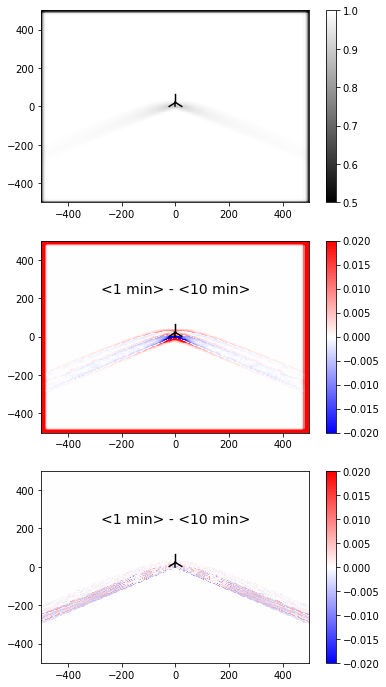

In [24]:
import scipy.ndimage as ndimage
sigma_y = 2.0
sigma_x = 2.0
sigma = [sigma_y, sigma_x]
y = ndimage.filters.gaussian_filter(avg_shadow10minS/day10minS, sigma, mode='constant')

fig = plt.figure(figsize=(6,12))
plt.subplot(311)
plt.pcolormesh(xy,yx,y,norm=Normalize(0.5,1.0),cmap=cm.gray)
plt.colorbar()
plt.plot([0,0],[0,shadow1minS.tower_height/2.0],c='k')
plt.scatter(0,shadow1minS.tower_height/2.0,color='k',marker='2',s=300)
plt.subplot(312)
plt.pcolormesh(xy,yx,avg_shadow1minS/day1minS - y,norm=Normalize(-0.02,0.02),cmap=cm.bwr)
plt.plot([0,0],[0,shadow1minS.tower_height/2.0],c='k')
plt.colorbar()
plt.scatter(0,shadow1minS.tower_height/2.0,color='k',marker='2',s=300)
plt.text(0.0,210,'<1 min> - <10 min>',ha='center',va='bottom',size=14)
plt.subplot(313)
plt.pcolormesh(xy,yx,avg_shadow1minS/day1minS - avg_shadow10minS/day10minS,norm=Normalize(-0.02,0.02),cmap=cm.bwr)
plt.plot([0,0],[0,shadow1minS.tower_height/2.0],c='k')
plt.colorbar()
plt.scatter(0,shadow1minS.tower_height/2.0,color='k',marker='2',s=300)
plt.text(0.0,210,'<1 min> - <10 min>',ha='center',va='bottom',size=14)
plt.show()


In [31]:
start_date = '2019-01-01 08:00:00'
shadow1minW  = shadowCast(date_start=start_date,data_freq='1min',ntimes=24*60+1,
                    latoi=39.91,lonoi=-105.23,tower_height=50.0,tower_width=5.0,dx=4.0,dy=4.0,lx=1000.0,ly=1000.0)
print 'done 1 min'
shadow10minW = shadowCast(date_start=start_date,data_freq='10min',ntimes=24*6+1,
                    latoi=39.91,lonoi=-105.23,tower_height=50.0,tower_width=5.0,dx=4.0,dy=4.0,lx=1000.0,ly=1000.0)
print 'done 10 min'
shadow30minW = shadowCast(date_start=start_date,data_freq='30min',ntimes=24*2+1,
                    latoi=39.91,lonoi=-105.23,tower_height=50.0,tower_width=5.0,dx=4.0,dy=4.0,lx=1000.0,ly=1000.0)
print 'done 30 min'
shadow60minW = shadowCast(date_start=start_date,data_freq='60min',ntimes=24+1,
                    latoi=39.91,lonoi=-105.23,tower_height=50.0,tower_width=5.0,dx=4.0,dy=4.0,lx=1000.0,ly=1000.0)

done 1 min
done 10 min
done 30 min


In [33]:
xy, yx = shadow1minW.xy, shadow1minW.yx
avg_shadow1minW  = np.zeros(np.shape(shadow1minW.xyc))
avg_shadow10minW = np.zeros(np.shape(shadow1minW.xyc))
avg_shadow30minW = np.zeros(np.shape(shadow1minW.xyc))
avg_shadow60minW = np.zeros(np.shape(shadow1minW.xyc))
day1minW  = 0.0
day10minW = 0.0
day30minW = 0.0
day60minW = 0.0
for tt in range(0,np.shape(shadow1minW.times)[0]):
    if np.shape(np.where(shadow1minW.shadow[:,:,tt] == 1.0))[1] != int(np.shape(xy)[0]-1)*int(np.shape(xy)[1]-1):
        avg_shadow1minW += shadow1minW.shadow[:,:,tt]
        day1minW += 1.0
print 'done 1 min'
for tt in range(0,np.shape(shadow10minW.times)[0]):
    if np.shape(np.where(shadow10minW.shadow[:,:,tt] == 1.0))[1] != int(np.shape(xy)[0]-1)*int(np.shape(xy)[1]-1):
        avg_shadow10minW += shadow10minW.shadow[:,:,tt]
        day10minW += 1.0
print 'done 10 min'
for tt in range(0,np.shape(shadow30minW.times)[0]):
    if np.shape(np.where(shadow30minW.shadow[:,:,tt] == 1.0))[1] != int(np.shape(xy)[0]-1)*int(np.shape(xy)[1]-1):
        avg_shadow30minW += shadow30minW.shadow[:,:,tt]
        day30minW += 1.0
print 'done 30 min'
for tt in range(0,np.shape(shadow60minW.times)[0]):
    if np.shape(np.where(shadow60minW.shadow[:,:,tt] == 1.0))[1] != int(np.shape(xy)[0]-1)*int(np.shape(xy)[1]-1):
        avg_shadow60minW += shadow60minW.shadow[:,:,tt]
        day60minW += 1.0

done 1 min
done 10 min
done 30 min


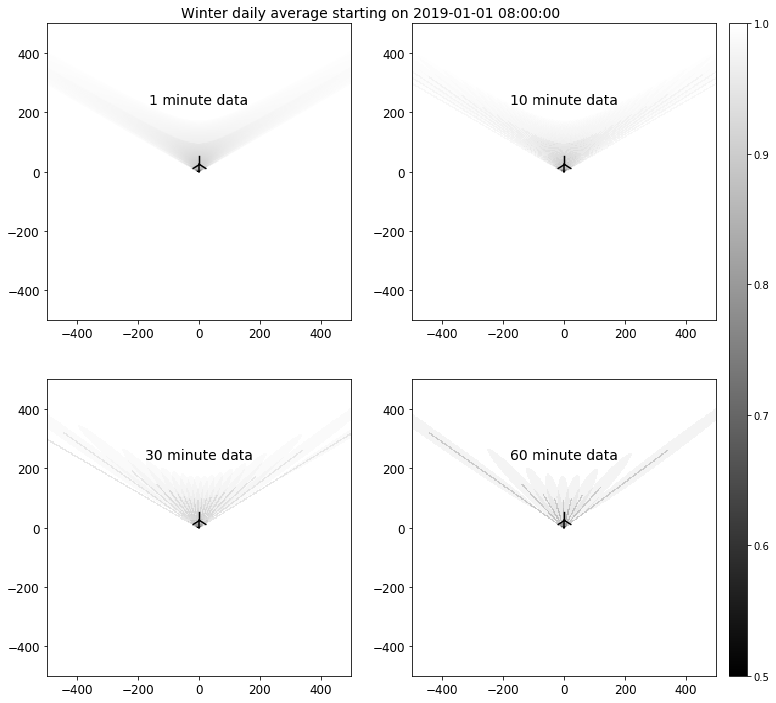

In [34]:
fig = plt.figure(figsize=(12,12))
sh1min = plt.subplot2grid((2,2),(0,0))
sh10min = plt.subplot2grid((2,2),(0,1))
sh30min = plt.subplot2grid((2,2),(1,0))
sh60min = plt.subplot2grid((2,2),(1,1))
sh1min.tick_params(labelsize=12)
sh10min.tick_params(labelsize=12)
sh30min.tick_params(labelsize=12)
sh60min.tick_params(labelsize=12)

plt1min = sh1min.pcolormesh(xy,yx,avg_shadow1minW/day1minW,norm=Normalize(0.5,1.0),cmap=cm.gray)
sh1min.plot([0,0],[0,shadow1minW.tower_height/2.0],c='k')
sh1min.scatter(0,shadow1minW.tower_height/2.0,color='k',marker='2',s=300)
sh1min.text(0.0,220,'1 minute data',ha='center',va='bottom',size=14)

sh10min.pcolormesh(xy,yx,avg_shadow10minW/day10minW,norm=Normalize(0.5,1.0),cmap=cm.gray)
sh10min.plot([0,0],[0,shadow10minW.tower_height/2.0],c='k')
sh10min.scatter(0,shadow10minW.tower_height/2.0,color='k',marker='2',s=300)
sh10min.text(0.0,220,'10 minute data',ha='center',va='bottom',size=14)

sh30min.pcolormesh(xy,yx,avg_shadow30minW/day30minW,norm=Normalize(0.5,1.0),cmap=cm.gray)
sh30min.plot([0,0],[0,shadow30minW.tower_height/2.0],c='k')
sh30min.scatter(0,shadow30minW.tower_height/2.0,color='k',marker='2',s=300)
sh30min.text(0.0,220,'30 minute data',ha='center',va='bottom',size=14)

sh60min.pcolormesh(xy,yx,avg_shadow60minW/day60minW,norm=Normalize(0.5,1.0),cmap=cm.gray)
sh60min.plot([0,0],[0,shadow60minW.tower_height/2.0],c='k')
sh60min.scatter(0,shadow60minW.tower_height/2.0,color='k',marker='2',s=300)
sh60min.text(0.0,220,'60 minute data',ha='center',va='bottom',size=14)

plt.suptitle('Winter daily average starting on {}'.format(start_date),x=0.5,y=0.9,size=14,ha='center',va='top')
cax = fig.add_axes([0.915,0.125,0.02,0.755])
plt.colorbar(plt1min,cax)
plt.show()